In [ ]:
from google.colab import files

# Upload kaggle.json from your PC
uploaded = files.upload()

# ✅ Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# ✅ Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configured successfully!")


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully!


In [ ]:

# ✅ Download MSTAR dataset from Kaggle
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset

# ✅ Define dataset path
DATASET_PATH = "/content/MSTAR_Dataset/Padded_imgs"

print("✅ MSTAR Dataset downloaded and extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown
100% 444M/444M [00:22<00:00, 23.6MB/s]
100% 444M/444M [00:22<00:00, 20.7MB/s]
✅ MSTAR Dataset downloaded and extracted successfully!


In [ ]:
!pip install timm tqdm opencv-python numpy torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader, Dataset
import timm
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ✅ Set Dataset Path
CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 128

def load_mstar_dataset(dataset_path, img_size):
    X, y = [], []

    for label, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
                img = cv2.resize(img, (img_size, img_size))  # Resize image
                X.append(img)
                y.append(label)

    X = np.array(X).reshape(-1, img_size, img_size, 1).astype(np.float32) / 255.0  # ✅ Convert to float32
    y = np.array(y, dtype=np.int64)  # ✅ Convert labels to int64

    # ✅ Split dataset into Train (80%) and Test (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

# ✅ Load Dataset
X_train, X_test, y_train, y_test = load_mstar_dataset(DATASET_PATH, IMG_SIZE)


In [ ]:
# ✅ Define PyTorch Dataset Class
class RadarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)  # ✅ Ensure images are float32
        self.labels = labels.astype(np.int64)  # ✅ Convert labels to int64
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
        image = cv2.resize(image, (224, 224))  # Resize for ViT
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# ✅ Define Data Augmentation & Create DataLoaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Create DataLoaders
train_dataset = RadarDataset(X_train, y_train, transform)
test_dataset = RadarDataset(X_test, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# ✅ Set Device for Training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Pretrained Vision Transformer (ViT)
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(CLASSES)).to(device)

# ✅ Set Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)  # ✅ Lower learning rate for fine-tuning


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# ✅ Train ViT Model for 15 Epochs with Progress Display
def train_vit(model, train_loader, epochs=15):
    model.train()
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            # ✅ Update progress bar with loss & accuracy
            loop.set_postfix(loss=loss.item(), accuracy=correct / total)

        avg_loss = running_loss / len(train_loader)
        avg_acc = correct / total
        print(f"🔹 Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_acc:.4f}")

# ✅ Train the Model
train_vit(vit_model, train_loader, epochs=15)


Epoch 1/15: 100%|██████████| 237/237 [04:12<00:00,  1.06s/it, accuracy=0.953, loss=0.00127]


🔹 Epoch 1/15 - Loss: 0.1430 - Accuracy: 0.9530


Epoch 2/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=0.998, loss=9.68e-5]


🔹 Epoch 2/15 - Loss: 0.0088 - Accuracy: 0.9979


Epoch 3/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=6.25e-5]


🔹 Epoch 3/15 - Loss: 0.0001 - Accuracy: 1.0000


Epoch 4/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=5.47e-5]


🔹 Epoch 4/15 - Loss: 0.0001 - Accuracy: 1.0000


Epoch 5/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=2.47e-5]


🔹 Epoch 5/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 6/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=2.79e-5]


🔹 Epoch 6/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 7/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=8.66e-6]


🔹 Epoch 7/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 8/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=2.01e-5]


🔹 Epoch 8/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 9/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=8.63e-6]


🔹 Epoch 9/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 10/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=2.66e-5]


🔹 Epoch 10/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 11/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=3.27e-6]


🔹 Epoch 11/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 12/15: 100%|██████████| 237/237 [04:21<00:00,  1.10s/it, accuracy=1, loss=5.78e-6]


🔹 Epoch 12/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 13/15: 100%|██████████| 237/237 [04:20<00:00,  1.10s/it, accuracy=1, loss=4.14e-6]


🔹 Epoch 13/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 14/15: 100%|██████████| 237/237 [04:18<00:00,  1.09s/it, accuracy=1, loss=9.43e-6]


🔹 Epoch 14/15 - Loss: 0.0000 - Accuracy: 1.0000


Epoch 15/15: 100%|██████████| 237/237 [04:13<00:00,  1.07s/it, accuracy=1, loss=8.41e-6]

🔹 Epoch 15/15 - Loss: 0.0000 - Accuracy: 1.0000


In [ ]:
 # ✅ Evaluate ViT Model with Progress Display
def evaluate_vit(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    loop = tqdm(test_loader, desc="Evaluating Model", leave=True)

    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    final_acc = correct / total
    print(f"🏆 ViT Test Accuracy: {final_acc:.4f}")

# ✅ Evaluate the Model
evaluate_vit(vit_model, test_loader)


Evaluating Model: 100%|██████████| 60/60 [00:21<00:00,  2.81it/s]

🏆 ViT Test Accuracy: 1.0000


In [ ]:
torch.save(vit_model.state_dict(), "vit_mstar_model.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
# ✅ Updated Function to Check Validation Accuracy
def evaluate_vit(model, test_loader):
    model.eval()  # ✅ Set model to evaluation mode
    correct = 0
    total = 0
    loop = tqdm(test_loader, desc="Evaluating Model", leave=True)

    with torch.no_grad():  # ✅ Disable gradient calculation
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total  # ✅ Compute validation accuracy
    print(f"🏆 ViT Validation Accuracy: {val_acc:.4f}")  # ✅ Print accuracy
    return val_acc  # ✅ Return accuracy value


In [ ]:
validation_accuracy = evaluate_vit(vit_model, test_loader)
print(f"✅ Final Validation Accuracy: {validation_accuracy:.4f}")


Evaluating Model: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]

🏆 ViT Validation Accuracy: 1.0000
✅ Final Validation Accuracy: 1.0000


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.78it/s]


🏆 ViT Validation Accuracy: 0.9646
🔹 Epoch 1/15 - Train Accuracy: 0.7925 - Val Accuracy: 0.9646


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.78it/s]


🏆 ViT Validation Accuracy: 0.9873
🔹 Epoch 2/15 - Train Accuracy: 0.9790 - Val Accuracy: 0.9873


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.78it/s]


🏆 ViT Validation Accuracy: 0.9937
🔹 Epoch 3/15 - Train Accuracy: 0.9901 - Val Accuracy: 0.9937


Evaluating Model: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


🏆 ViT Validation Accuracy: 0.9889
🔹 Epoch 4/15 - Train Accuracy: 0.9926 - Val Accuracy: 0.9889


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.77it/s]


🏆 ViT Validation Accuracy: 0.9979
🔹 Epoch 5/15 - Train Accuracy: 0.9889 - Val Accuracy: 0.9979


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.77it/s]


🏆 ViT Validation Accuracy: 1.0000
🔹 Epoch 6/15 - Train Accuracy: 0.9976 - Val Accuracy: 1.0000


Evaluating Model: 100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


🏆 ViT Validation Accuracy: 0.9937
🔹 Epoch 7/15 - Train Accuracy: 0.9979 - Val Accuracy: 0.9937


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


🏆 ViT Validation Accuracy: 0.9947
🔹 Epoch 8/15 - Train Accuracy: 0.9982 - Val Accuracy: 0.9947


Evaluating Model: 100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


🏆 ViT Validation Accuracy: 0.9979
🔹 Epoch 9/15 - Train Accuracy: 0.9964 - Val Accuracy: 0.9979
⏹ Early Stopping: No improvement for 3 epochs


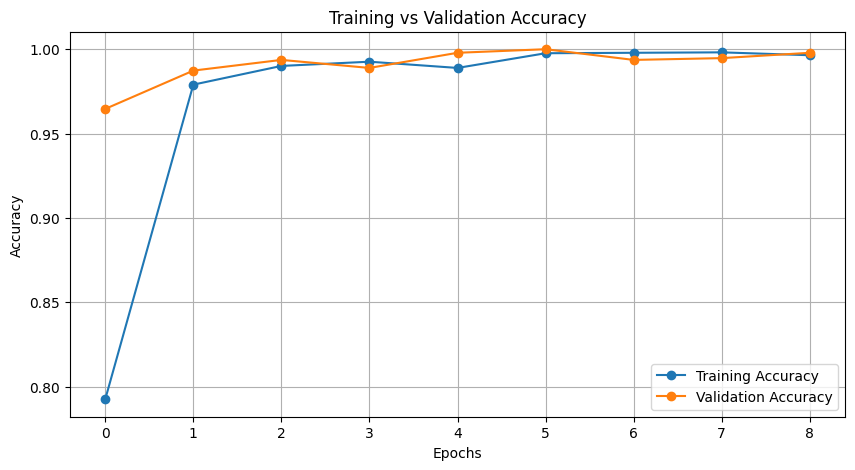

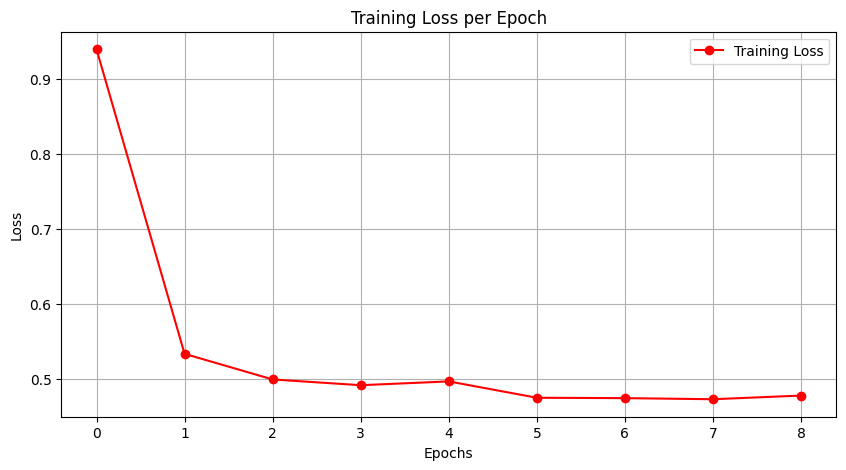

In [ ]:
# ✅ Install Dependencies
!pip install kaggle timm tqdm opencv-python numpy torch torchvision matplotlib

# ✅ Upload Kaggle API & Download Dataset
from google.colab import files
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import timm
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ✅ Upload kaggle.json
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ✅ Download & Extract Dataset
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset
DATASET_PATH = "/content/MSTAR_Dataset/Padded_imgs"

# ✅ Dataset Classes
CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 128

# ✅ Load MSTAR Dataset
def load_mstar_dataset(dataset_path, img_size):
    X, y = [], []
    for label, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(label)
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype(np.float32) / 255.0
    y = np.array(y, dtype=np.int64)
    return train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Load Data
X_train, X_test, y_train, y_test = load_mstar_dataset(DATASET_PATH, IMG_SIZE)

from PIL import Image

# ✅ PyTorch Dataset Class
class RadarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
        image = cv2.resize(image, (224, 224))  # Resize for ViT

        # ✅ Convert to PIL image before applying transformations
        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# ✅ Data Augmentation & DataLoaders
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = RadarDataset(X_train, y_train, transform)
test_dataset = RadarDataset(X_test, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Load Pretrained ViT Model & Modify for Overfitting Reduction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(CLASSES)).to(device)

# ✅ Add Dropout to ViT Model
vit_model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(vit_model.head.in_features, NUM_CLASSES)
).to(device)

# ✅ Loss Function, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Apply Label Smoothing
optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ✅ Early Stopping Setup
best_val_acc = 0
patience = 3
epochs_no_improve = 0

# ✅ Training with Accuracy Tracking & Early Stopping
train_accuracies, val_accuracies, losses = [], [], []

def train_vit(model, train_loader, test_loader, epochs=15):
    global best_val_acc, epochs_no_improve
    model.train()

    for epoch in range(epochs):
        correct_train, total_train, running_loss = 0, 0, 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
            loop.set_postfix(loss=loss.item(), accuracy=correct_train / total_train)

        train_acc = correct_train / total_train
        val_acc = evaluate_vit(model, test_loader)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        losses.append(running_loss / len(train_loader))

        print(f"🔹 Epoch {epoch+1}/{epochs} - Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⏹ Early Stopping: No improvement for {patience} epochs")
                break

        scheduler.step()

# ✅ Evaluate ViT Model
def evaluate_vit(model, test_loader):
    model.eval()
    correct, total = 0, 0
    loop = tqdm(test_loader, desc="Evaluating Model")

    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"🏆 ViT Validation Accuracy: {val_acc:.4f}")
    return val_acc

# ✅ Train Model with 15 Epochs
train_vit(vit_model, train_loader, test_loader, epochs=15)

# ✅ Plot Accuracy Graphs
plt.figure(figsize=(10,5))
plt.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plot Loss Graph
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses, label="Training Loss", color='red', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch

# Save the entire ViT model
torch.save(vit_model, "vit_mstar_model.pth")

print("✅ ViT Model saved successfully!")


✅ ViT Model saved successfully!


In [ ]:
from google.colab import files

# Download the saved model
files.download("vit_mstar_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Save to a specific folder in Google Drive
torch.save(vit_model, '/content/drive/MyDrive/vit_mstar_model.pth')
print("✅ Model saved to Google Drive!")


✅ Model saved to Google Drive!


In [ ]:
import torch

# ✅ Load the model with weights_only=False
model_path = "/content/drive/MyDrive/vit_mstar_model.pth"
vit_model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
vit_model.eval()

print("✅ ViT model loaded successfully!")


✅ ViT model loaded successfully!


In [ ]:
#EfficientNet

Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown
100% 443M/444M [00:22<00:00, 22.7MB/s]
100% 444M/444M [00:22<00:00, 21.0MB/s]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 49.7MB/s]


🚀 Training EfficientNet...


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.69it/s]


🏆 Validation Accuracy: 0.8854
🔹 Epoch 1/10 - Train Accuracy: 0.6144 - Val Accuracy: 0.8854


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.71it/s]


🏆 Validation Accuracy: 0.9372
🔹 Epoch 2/10 - Train Accuracy: 0.9110 - Val Accuracy: 0.9372


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.62it/s]


🏆 Validation Accuracy: 0.9630
🔹 Epoch 3/10 - Train Accuracy: 0.9653 - Val Accuracy: 0.9630


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]


🏆 Validation Accuracy: 0.9688
🔹 Epoch 4/10 - Train Accuracy: 0.9761 - Val Accuracy: 0.9688


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.67it/s]


🏆 Validation Accuracy: 0.9884
🔹 Epoch 5/10 - Train Accuracy: 0.9794 - Val Accuracy: 0.9884


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


🏆 Validation Accuracy: 0.9926
🔹 Epoch 6/10 - Train Accuracy: 0.9927 - Val Accuracy: 0.9926


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.73it/s]


🏆 Validation Accuracy: 0.9900
🔹 Epoch 7/10 - Train Accuracy: 0.9921 - Val Accuracy: 0.9900


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


🏆 Validation Accuracy: 0.9894
🔹 Epoch 8/10 - Train Accuracy: 0.9950 - Val Accuracy: 0.9894


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


🏆 Validation Accuracy: 0.9926
🔹 Epoch 9/10 - Train Accuracy: 0.9912 - Val Accuracy: 0.9926


Evaluating Model: 100%|██████████| 60/60 [00:16<00:00,  3.75it/s]


🏆 Validation Accuracy: 0.9873
🔹 Epoch 10/10 - Train Accuracy: 0.9945 - Val Accuracy: 0.9873


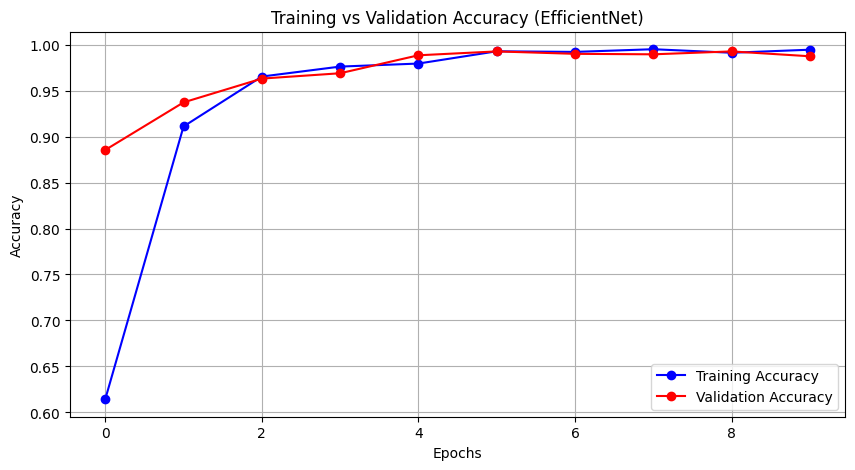

In [ ]:
# ✅ Install Dependencies (Only Needed if Not Installed)
!pip install kaggle timm torchvision torch tqdm opencv-python numpy matplotlib

# ✅ Import Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

# ✅ Download & Extract MSTAR Dataset
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset
DATASET_PATH = "/content/MSTAR_Dataset/Padded_imgs"

# ✅ Define Dataset Classes
CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 128

# ✅ Load MSTAR Dataset
def load_mstar_dataset(dataset_path, img_size):
    X, y = [], []
    for label, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(label)
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype(np.float32) / 255.0
    y = np.array(y, dtype=np.int64)
    return train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Load Data
X_train, X_test, y_train, y_test = load_mstar_dataset(DATASET_PATH, IMG_SIZE)

# ✅ Define PyTorch Dataset Class
class RadarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
        image = cv2.resize(image, (224, 224))
        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# ✅ Data Augmentation & DataLoaders
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = RadarDataset(X_train, y_train, transform)
test_dataset = RadarDataset(X_test, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Load Pretrained EfficientNet Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

efficientnet_model = models.efficientnet_b0(pretrained=True)

# ✅ Modify the Final Layer for MSTAR Classification
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Prevent Overfitting
    nn.Linear(efficientnet_model.classifier[-1].in_features, NUM_CLASSES)
)

efficientnet_model = efficientnet_model.to(device)

# ✅ Loss Function, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ✅ Training Function
def train_model(model, optimizer, scheduler, train_loader, test_loader, epochs=10):
    model.train()
    train_accuracies, val_accuracies, losses = [], [], []

    for epoch in range(epochs):
        correct_train, total_train, running_loss = 0, 0, 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
            loop.set_postfix(loss=loss.item(), accuracy=correct_train / total_train)

        train_acc = correct_train / total_train
        val_acc = evaluate_model(model, test_loader)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        losses.append(running_loss / len(train_loader))

        print(f"🔹 Epoch {epoch+1}/{epochs} - Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f}")

        scheduler.step()

    return train_accuracies, val_accuracies, losses

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    loop = tqdm(test_loader, desc="Evaluating Model")

    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"🏆 Validation Accuracy: {val_acc:.4f}")
    return val_acc

# ✅ Train & Evaluate EfficientNet
print("🚀 Training EfficientNet...")
train_acc, val_acc, loss = train_model(efficientnet_model, optimizer, scheduler, train_loader, test_loader, epochs=10)

# ✅ Plot Accuracy Graphs
plt.figure(figsize=(10,5))
plt.plot(range(len(train_acc)), train_acc, label="Training Accuracy", marker='o', color='blue')
plt.plot(range(len(val_acc)), val_acc, label="Validation Accuracy", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (EfficientNet)")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()  # Select your file from local PC


Saving efficientnet_mstar.pth to efficientnet_mstar.pth


In [ ]:
import shutil

# Move the file from Colab to Google Drive
shutil.move("efficientnet_mstar.pth", "/content/drive/MyDrive/efficientnet_mstar.pth")

print("✅ EfficientNet model uploaded to Google Drive successfully!")


✅ EfficientNet model uploaded to Google Drive successfully!


In [ ]:
# ✅ Save the Entire Model
torch.save(efficientnet_model, "efficientnet_mstar.pth")
print("✅ Model saved as 'efficientnet_mstar.pth'")

✅ Model saved as 'efficientnet_mstar.pth'


In [ ]:
from google.colab import files
files.download("efficientnet_mstar.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

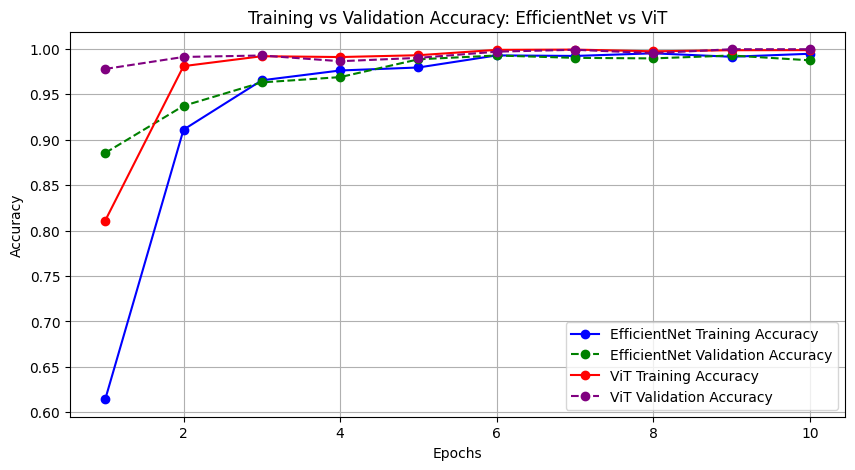

In [ ]:
import matplotlib.pyplot as plt

# ✅ Define accuracy values
efficientnet_train_acc = [0.6144, 0.9110, 0.9653, 0.9761, 0.9794, 0.9927, 0.9921, 0.9950, 0.9912, 0.9945]
efficientnet_val_acc = [0.8854, 0.9372, 0.9630, 0.9688, 0.9884, 0.9926, 0.9900, 0.9894, 0.9926, 0.9873]

vit_train_acc = [0.8110, 0.9809, 0.9918, 0.9909, 0.9929, 0.9988, 0.9991, 0.9972, 0.9984, 0.9985]
vit_val_acc = [0.9778, 0.9910, 0.9926, 0.9863, 0.9900, 0.9968, 0.9989, 0.9952, 0.9995, 0.9995]

epochs = range(1, len(efficientnet_train_acc) + 1)

# ✅ Plot Accuracy Comparison with 4 Different Colors
plt.figure(figsize=(10, 5))
plt.plot(epochs, efficientnet_train_acc, label="EfficientNet Training Accuracy", marker='o', linestyle='-', color='blue')
plt.plot(epochs, efficientnet_val_acc, label="EfficientNet Validation Accuracy", marker='o', linestyle='--', color='green')
plt.plot(epochs, vit_train_acc, label="ViT Training Accuracy", marker='o', linestyle='-', color='red')
plt.plot(epochs, vit_val_acc, label="ViT Validation Accuracy", marker='o', linestyle='--', color='purple')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy: EfficientNet vs ViT")
plt.legend()
plt.grid(True)
plt.show()


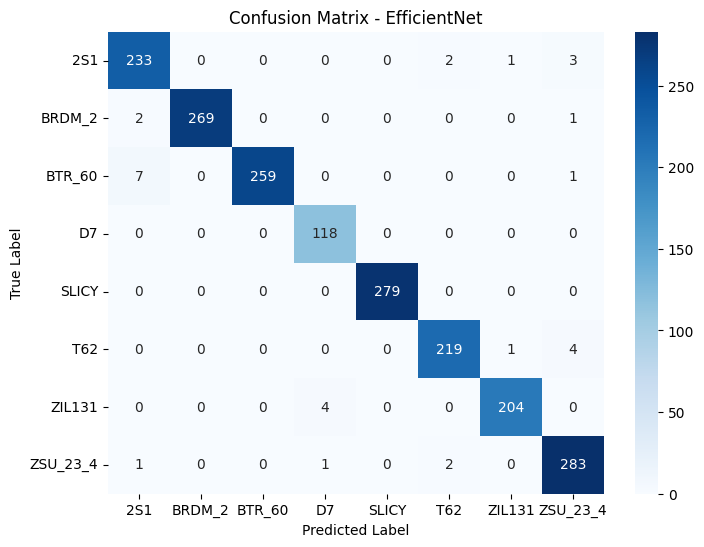

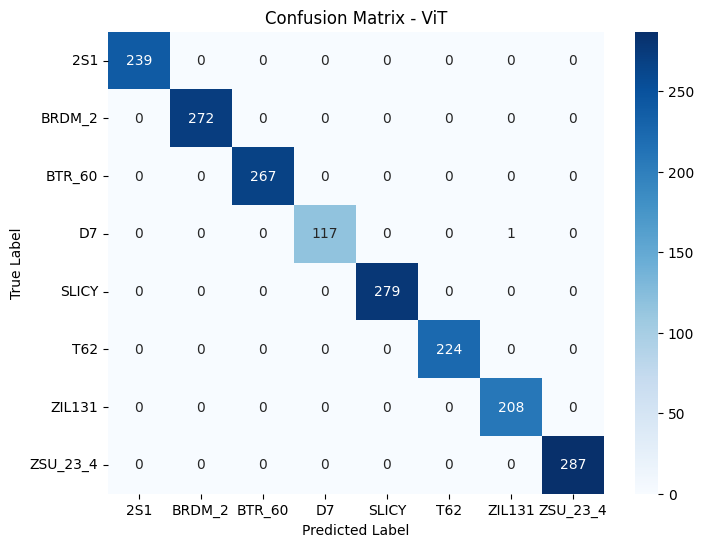

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# ✅ Function to Evaluate Model and Get Predictions
def get_predictions(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# ✅ Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# ✅ Compute Predictions for EfficientNet
efficientnet_preds, true_labels = get_predictions(efficientnet_model, test_loader, device)
plot_confusion_matrix(true_labels, efficientnet_preds, CLASSES, "EfficientNet")

# ✅ Compute Predictions for ViT
vit_preds, true_labels = get_predictions(vit_model, test_loader, device)
plot_confusion_matrix(true_labels, vit_preds, CLASSES, "ViT")


In [ ]:
from google.colab import files

# Upload model manually
uploaded = files.upload()


Saving efficientnet_mstar.pth to efficientnet_mstar.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mv efficientnet_mstar.pth /content/drive/MyDrive/
print("✅ EfficientNet model moved to Google Drive successfully!")


✅ EfficientNet model moved to Google Drive successfully!


In [ ]:
import os

model_path = "/content/drive/MyDrive/efficientnet_mstar.pth"
print("✅ File found!" if os.path.exists(model_path) else "❌ File not found!")


✅ File found!


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load the full EfficientNet model directly (only if you're sure it's safe — which it is, since you trained it)
efficientnet_model = torch.load("/content/drive/MyDrive/efficientnet_mstar.pth", map_location=device, weights_only=False)
efficientnet_model.eval()

print("✅ EfficientNet model loaded successfully!")


✅ EfficientNet model loaded successfully!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def evaluate_model_with_report(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🧾 Classification Report
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 📊 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - EfficientNet")
    plt.grid(False)
    plt.show()


In [ ]:
from google.colab import files
files.upload()  # Then select kaggle.json from your computer


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"bergen6608","key":"50bbb700a673aef8d325007aa9cb7f6f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset


Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown


In [ ]:
!ls /content/MSTAR_Dataset/Padded_imgs


2S1  BRDM_2  BTR_60  D7  SLICY	T62  ZIL131  ZSU_23_4


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from PIL import Image

# ✅ Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Define Dataset Class
class RadarDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.images, self.labels = self.load_dataset(dataset_path)
        self.transform = transform

    def load_dataset(self, dataset_path):
        X, y = [], []
        CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]
        for label, class_name in enumerate(CLASSES):
            class_path = f"{dataset_path}/{class_name}"
            for img_name in os.listdir(class_path):
                img_path = f"{class_path}/{img_name}"
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (224, 224))  # Resize for ViT & EfficientNet
                X.append(img)
                y.append(label)
        X = np.array(X).reshape(-1, 224, 224, 1).astype(np.float32) / 255.0
        y = np.array(y, dtype=np.int64)
        return X, y

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to PIL

        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# ✅ Create Test Dataset & DataLoader
DATASET_PATH = "/content/MSTAR_Dataset/Padded_imgs"
test_dataset = RadarDataset(DATASET_PATH, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Test DataLoader created successfully!")


✅ Test DataLoader created successfully!


In [ ]:
import torch
import timm

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load ViT Model with weights_only=False
vit_model_path = "/content/drive/MyDrive/vit_mstar_model.pth"  # Update if needed
vit_model = torch.load(vit_model_path, map_location=device, weights_only=False)
vit_model.eval()

print("✅ ViT model loaded successfully!")


✅ ViT model loaded successfully!


In [ ]:
from sklearn.metrics import classification_report
import torch

# ✅ Function to Generate Classification Report
def evaluate_model_with_report(model, test_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ✅ Print Classification Report
    print(f"\n📊 Classification Report for {model.__class__.__name__}:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

# ✅ Generate Reports for Both Models
CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]

print("📢 Generating classification report for **ViT Model**...")
evaluate_model_with_report(vit_model, test_loader, CLASSES)


📢 Generating classification report for **ViT Model**...

📊 Classification Report for VisionTransformer:

              precision    recall  f1-score   support

         2S1       0.97      0.98      0.98      1164
      BRDM_2       1.00      0.94      0.97      1415
      BTR_60       0.99      1.00      1.00      1353
          D7       1.00      0.97      0.98       573
       SLICY       1.00      1.00      1.00      1270
         T62       0.99      1.00      0.99      1144
      ZIL131       0.99      1.00      1.00      1146
    ZSU_23_4       0.96      1.00      0.98      1401

    accuracy                           0.99      9466
   macro avg       0.99      0.99      0.99      9466
weighted avg       0.99      0.99      0.99      9466



In [ ]:
from sklearn.metrics import classification_report
import torch

# ✅ Function to Evaluate the Model and Generate a Classification Report
def evaluate_model_with_report(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # ✅ Generate Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
print("📢 Generating Classification Report for **ViT Model**...")
evaluate_model_with_report(vit_model, test_loader, CLASSES)

print("\n📢 Generating Classification Report for **EfficientNet Model**...")
evaluate_model_with_report(efficientnet_model, test_loader, CLASSES)


📢 Generating Classification Report for **ViT Model**...
              precision    recall  f1-score   support

         2S1       0.97      0.98      0.98      1164
      BRDM_2       1.00      0.94      0.97      1415
      BTR_60       0.99      1.00      1.00      1353
          D7       1.00      0.97      0.98       573
       SLICY       1.00      1.00      1.00      1270
         T62       0.99      1.00      0.99      1144
      ZIL131       0.99      1.00      1.00      1146
    ZSU_23_4       0.96      1.00      0.98      1401

    accuracy                           0.99      9466
   macro avg       0.99      0.99      0.99      9466
weighted avg       0.99      0.99      0.99      9466


📢 Generating Classification Report for **EfficientNet Model**...
              precision    recall  f1-score   support

         2S1       0.73      0.88      0.80      1164
      BRDM_2       1.00      0.66      0.80      1415
      BTR_60       1.00      0.98      0.99      1353
          

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
vit_path = "/content/drive/MyDrive/Colab Models/vit_mstar_model.pth"
effnet_path = "/content/drive/MyDrive/Colab Models/efficientnet_mstar.pth"


In [6]:
vit_model = torch.load(vit_path, map_location=device, weights_only=False)
vit_model.eval()
print("✅ ViT model loaded successfully!")


✅ ViT model loaded successfully!


In [7]:
efficientnet_model = torch.load(effnet_path, map_location=device, weights_only=False)
efficientnet_model.eval()
print("✅ EfficientNet model loaded successfully!")


✅ EfficientNet model loaded successfully!


In [9]:
import torch

# Load the saved model
efficientnet_model = torch.load("/content/drive/MyDrive/efficientnet_mstar.pth", map_location="cuda", weights_only=False)
print("✅ EfficientNet Model Loaded Successfully!")


✅ EfficientNet Model Loaded Successfully!


In [13]:
from google.colab import files
files.upload()  # Select kaggle.json from your local PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bergen6608","key":"50bbb700a673aef8d325007aa9cb7f6f"}'}

In [14]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [15]:
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset


Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown


In [16]:
!ls /content/MSTAR_Dataset/Padded_imgs


2S1  BRDM_2  BTR_60  D7  SLICY	T62  ZIL131  ZSU_23_4


In [17]:
X, y = load_mstar_dataset(DATASET_PATH, IMG_SIZE)
print(f"Total Images: {len(X)}, Labels: {len(y)}")

# ✅ Create dataset & dataloaders
dataset = RadarDataset(X, y, transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("✅ Dataset Loaded Successfully!")


Total Images: 9466, Labels: 9466
✅ Dataset Loaded Successfully!


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Pretrained EfficientNet Model
efficientnet_model = models.efficientnet_b0(pretrained=True)

# ✅ Modify Final Layers for Classification
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.4),  # 🔹 Increased Dropout to Reduce Overfitting
    nn.Linear(efficientnet_model.classifier[-1].in_features, len(CLASSES))
).to(device)

# ✅ Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 🔹 Label Smoothing Applied
optimizer = optim.AdamW(efficientnet_model.parameters(), lr=5e-5, weight_decay=1e-4)  # 🔹 Weight Decay Added
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("✅ EfficientNet Model Ready for Training!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s]


✅ EfficientNet Model Ready for Training!


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from google.colab import files

# Upload kaggle.json (Download it from https://www.kaggle.com/account)
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bergen6608","key":"50bbb700a673aef8d325007aa9cb7f6f"}'}

In [5]:
import os

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Replace the dataset name if needed
!kaggle datasets download -d atreyamajumdar/mstar-dataset-8-classes --unzip -p /content/MSTAR_Dataset


Dataset URL: https://www.kaggle.com/datasets/atreyamajumdar/mstar-dataset-8-classes
License(s): unknown


In [7]:
dataset_path = "/content/MSTAR_Dataset/Padded_imgs"

if os.path.exists(dataset_path):
    print(f"✅ Dataset successfully downloaded and extracted at: {dataset_path}")
    print("📂 Listing dataset folders:")
    print(os.listdir(dataset_path))
else:
    print("❌ Dataset download failed. Check the Kaggle API setup.")


✅ Dataset successfully downloaded and extracted at: /content/MSTAR_Dataset/Padded_imgs
📂 Listing dataset folders:
['2S1', 'BTR_60', 'ZIL131', 'SLICY', 'BRDM_2', 'D7', 'T62', 'ZSU_23_4']


In [8]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define classes
CLASSES = ["2S1", "BRDM_2", "BTR_60", "D7", "SLICY", "T62", "ZIL131", "ZSU_23_4"]
IMG_SIZE = 128

# Function to load images
def load_mstar_dataset(dataset_path, img_size):
    X, y = [], []
    for label, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(label)
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype(np.float32) / 255.0
    y = np.array(y, dtype=np.int64)
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Load Data
X_train, X_test, y_train, y_test = load_mstar_dataset(dataset_path, IMG_SIZE)

print("✅ Dataset successfully loaded!")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


✅ Dataset successfully loaded!
Training samples: 7572, Testing samples: 1894


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Convert dataset to NumPy array for statistics
X_train_flat = np.array(X_train).reshape(len(X_train), -1)  # Flatten each image
X_test_flat = np.array(X_test).reshape(len(X_test), -1)

# Compute mean and standard deviation
train_mean = np.mean(X_train_flat)
train_std = np.std(X_train_flat)
test_mean = np.mean(X_test_flat)
test_std = np.std(X_test_flat)

print(f"📊 Training Set Mean: {train_mean:.4f}, Standard Deviation: {train_std:.4f}")
print(f"📊 Testing Set Mean: {test_mean:.4f}, Standard Deviation: {test_std:.4f}")


📊 Training Set Mean: 0.2536, Standard Deviation: 0.2087
📊 Testing Set Mean: 0.2497, Standard Deviation: 0.2082


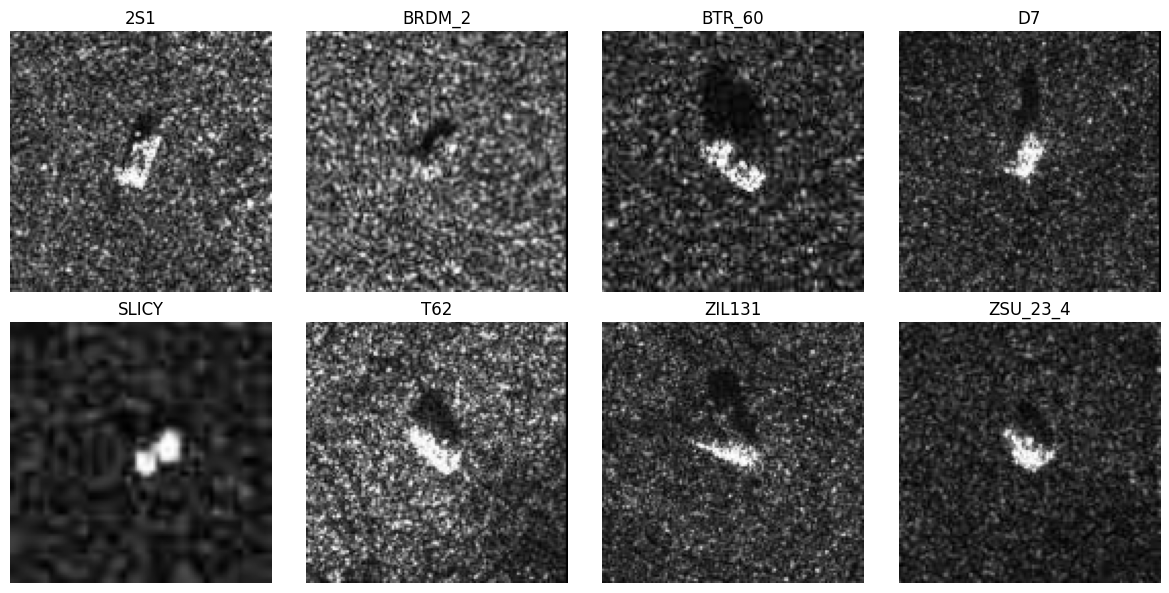

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, class_name in enumerate(CLASSES):
    idx = np.where(y_train_np == i)[0][0]  # Find an index for this class
    ax = axes[i // 4, i % 4]
    ax.imshow(X_train[idx].squeeze(), cmap='gray')
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# Convert dataset to NumPy array for statistics
X_train_flat = np.array(X_train).reshape(len(X_train), -1)  # Flatten each image
X_test_flat = np.array(X_test).reshape(len(X_test), -1)

# Compute mean and standard deviation
train_mean = np.mean(X_train_flat)
train_std = np.std(X_train_flat)
test_mean = np.mean(X_test_flat)
test_std = np.std(X_test_flat)

print(f"📊 Training Set Mean: {train_mean:.4f}, Standard Deviation: {train_std:.4f}")
print(f"📊 Testing Set Mean: {test_mean:.4f}, Standard Deviation: {test_std:.4f}")


📊 Training Set Mean: 0.2536, Standard Deviation: 0.2087
📊 Testing Set Mean: 0.2497, Standard Deviation: 0.2082


In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for model input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

# ✅ Define Dataset Paths
dataset_path = "/content/MSTAR_Dataset/Padded_imgs"

# ✅ Load Dataset
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# ✅ Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ✅ Define Classes
CLASSES = train_dataset.classes

print(f"✅ Dataset Loaded: {len(train_dataset)} samples, {len(CLASSES)} classes")


✅ Dataset Loaded: 9466 samples, 8 classes


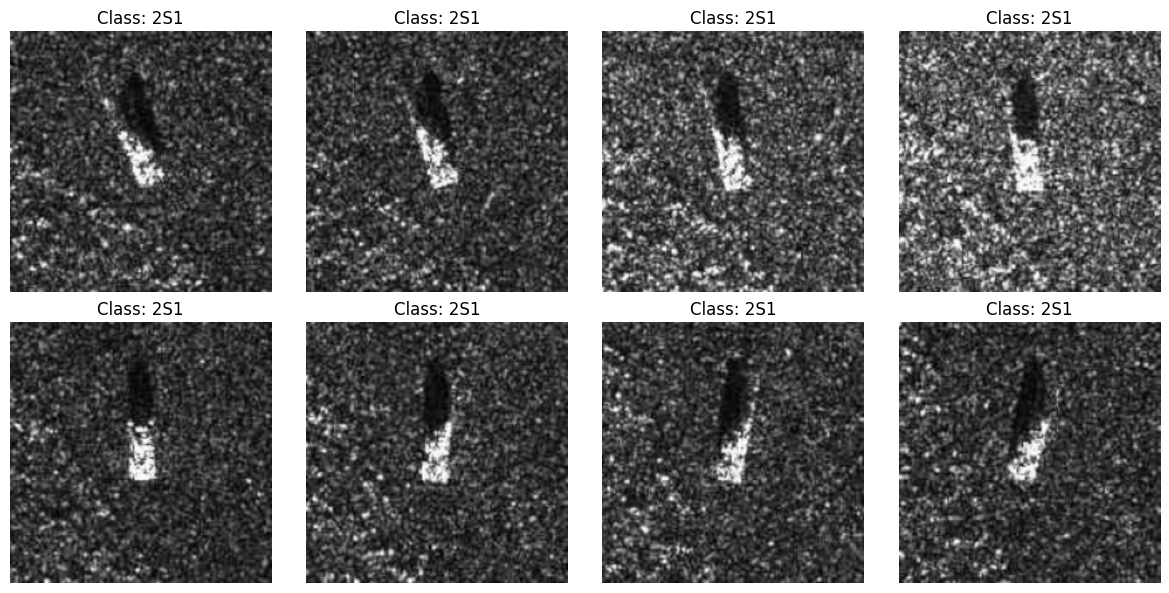

In [17]:
import matplotlib.pyplot as plt

# Function to display random images from the dataset
def plot_sample_images(dataset, classes, num_images=8):
    fig, axes = plt.subplots(2, num_images//2, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy for visualization
        img = (img * 0.5) + 0.5  # Undo normalization

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Class: {classes[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Call the function to visualize sample images
plot_sample_images(train_dataset, CLASSES)


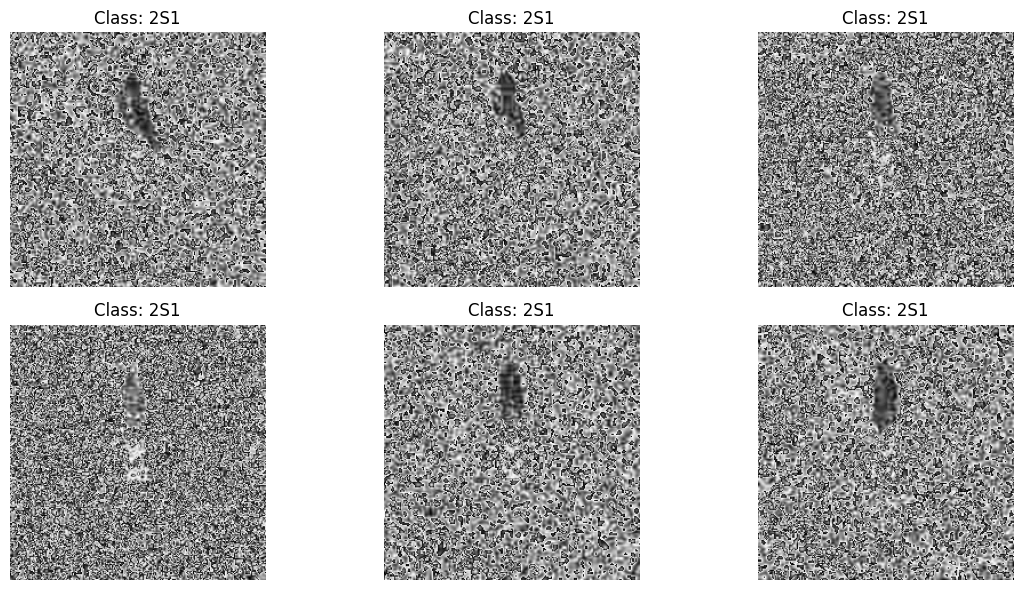

In [19]:
from torchvision import transforms
from PIL import Image

# ✅ Function to visualize augmented images
def plot_augmented_images(dataset, transform, num_images=6):
    fig, axes = plt.subplots(2, num_images//2, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img, label = dataset[i]  # Get tensor image
        img = transforms.ToPILImage()(img)  # Convert Tensor to PIL
        img = transform(img)  # Apply augmentation
        img = transforms.ToPILImage()(img)  # Convert back for visualization

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Class: {CLASSES[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Call function with dataset transformations
plot_augmented_images(train_dataset, transform)


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for model input
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize
])


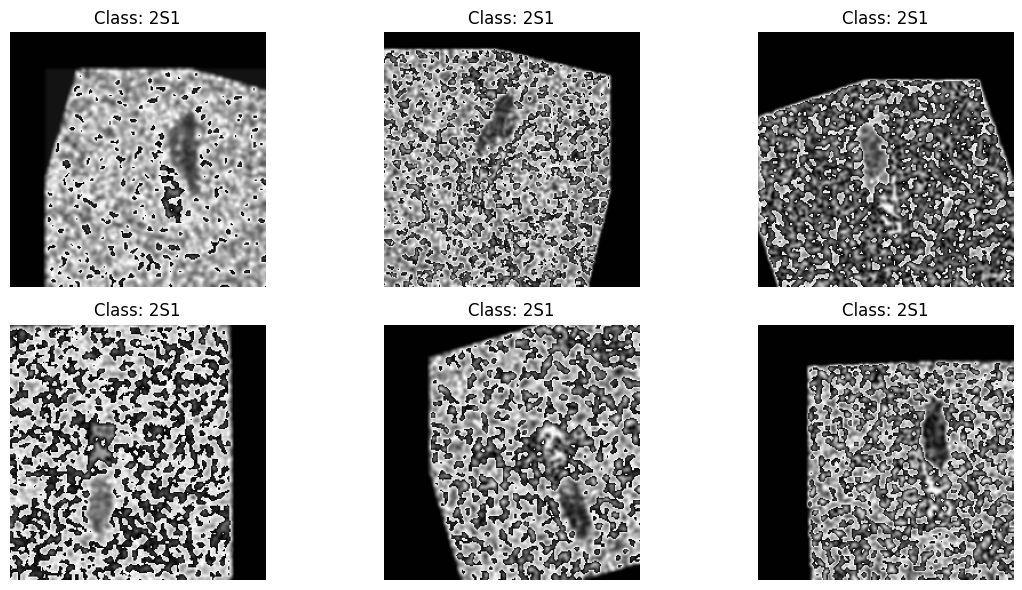

In [22]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToPILImage
from PIL import Image

# ✅ Define transformation (same one used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Function to visualize augmented images
def plot_augmented_images(dataset, transform, num_images=6):
    fig, axes = plt.subplots(2, num_images // 2, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img_tensor, label = dataset[i]
        # Convert tensor back to PIL before applying transform
        img_pil = ToPILImage()(img_tensor)
        img_aug = transform(img_pil)
        img_vis = ToPILImage()(img_aug)  # Convert to displayable format

        axes[i].imshow(img_vis, cmap='gray')
        axes[i].set_title(f"Class: {CLASSES[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Visualize
plot_augmented_images(train_dataset, transform)
